# Bollinger Bands Strategy and Backtesting

Prepared by Samalie Piwan   
Email : spiwan@andrew.cmu.edu

Load the libraries to be used in the project

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_ta as ta
import seaborn as sns
import yfinance as yf
import requests
import os
import csv
import backtesting
from datetime import datetime, timedelta
from dateutil import parser
from backtesting import Backtest, Strategy
from tabulate import tabulate
from backtesting.lib import crossover, TrailingStrategy
import unittest
backtesting.set_bokeh_output(notebook=False)

## 1.Strategy Setup

### 1.1 Loading API data

Calculate the date ranges that will be used to load and slice the data

In [4]:
today = datetime.today().strftime('%Y-%m-%d')

In [5]:
last_729_days = (datetime.now() - timedelta(days = 729)).date()
last_729_days_date = last_729_days.strftime('%Y-%m-%d')

In [6]:
next_365_days = (last_729_days + timedelta(days = 365))
next_365_days_date = next_365_days.strftime('%Y-%m-%d')

In [7]:
next_366_days = (next_365_days + timedelta(days = 1))
next_366_days_date = next_366_days.strftime('%Y-%m-%d')

In [8]:
slice_one_end_date = next_365_days_date
slice_two_start_date = next_366_days_date

First, we set the initial parameters for loading the data. We also load the hourly data from the **Yahoo Finance** API.<br>
Because we cannot load data past 730 days from the API, we will load data from 20th October 2021 to 20th October 2023

In [62]:
forex_pair = "EURUSD=X"
interval = "1h"
start_date = last_729_days_date
end_date = today

In [63]:
price_data = yf.download(forex_pair, interval = interval, start = start_date)

[*********************100%%**********************]  1 of 1 completed


Next, we split the data into two datasets **insample_data** and **outsample_data**.
  - insample_data will contain data for one year, starting two years ago
  - outsample_data will contain data for one year, starting one years ago

In [65]:
insample_data = pd.DataFrame(price_data.loc[last_729_days_date : slice_one_end_date].copy())
outsample_data = pd.DataFrame(price_data.loc[slice_two_start_date:today].copy())

### 1.2 Strategy Background

#### Current Strategy

The current version of this repository uses the Bollinger Bands strategy

#### Additional Strategies

The following additional strategies have been added to the repository:
 - Relative Strength Index (RSI)
 - Moving Average Convergence Divergence (MACD)
 - Momentum Trading Strategy 
 - Stochastic Oscillator

### 1.3 Startegy setup with Pandas TA library

Set the global plot style

In [66]:
plt.style.use('ggplot')

**a) Bollinger Bands**

Create variables for the initial EMA window and Standard Deviation

In [67]:
init_ema_window = 60
init_std = 2

In [156]:
bb_plot_insample_df = insample_data.copy()
bbands = bb_plot_insample_df.ta.bbands(close = 'Close', length = init_ema_window,
                              std = init_std, mamode="ema", append=True)
bb_plot_insample_df.tail()

,Open,High,Low,Close,Adj Close,Volume,BBL_60_2.0,BBM_60_2.0,BBU_60_2.0,BBB_60_2.0,BBP_60_2.0
Datetime,,,,,,,,,,,
2022-11-29 19:00:00+00:00,1.034340,1.034875,1.032631,1.033058,1.033058,0,1.030446,1.037703,1.044961,1.398776,0.179954
2022-11-29 20:00:00+00:00,1.033058,1.033378,1.032524,1.032951,1.032951,0,1.030186,1.037548,1.044909,1.419016,0.187808
2022-11-29 21:00:00+00:00,1.032844,1.033378,1.032738,1.032844,1.032844,0,1.029969,1.037393,1.044818,1.431390,0.193660
2022-11-29 22:00:00+00:00,1.033165,1.034340,1.032951,1.032951,1.032951,0,1.029709,1.037248,1.044787,1.453649,0.215044
2022-11-29 23:00:00+00:00,1.033378,1.033378,1.032205,1.032418,1.032418,0,1.029472,1.037089,1.044707,1.469064,0.193386


Plot the Bollinger Bands

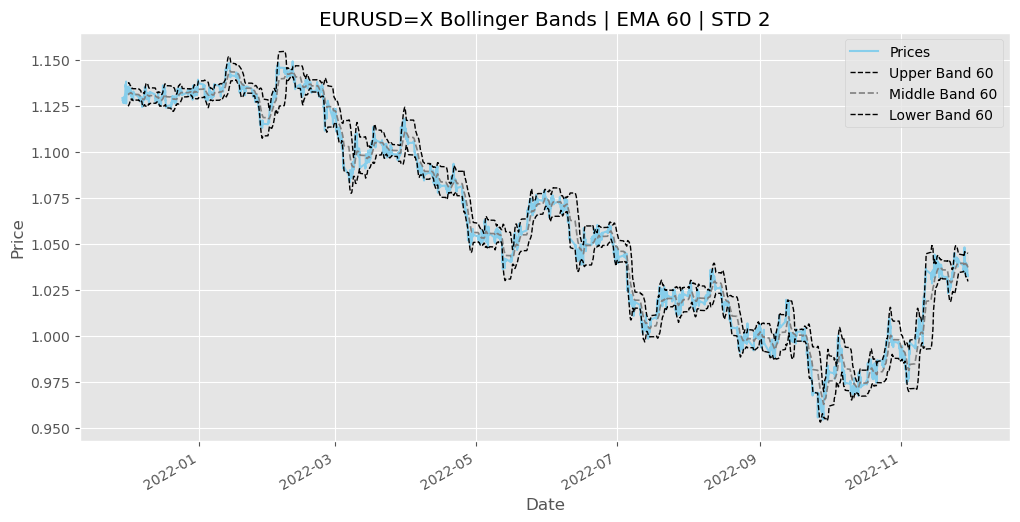

In [70]:
# Create f strings that match the column names created by the pandas ta library to reference the column data
str_upper_band = f"BBU_{init_ema_window}_{init_std}.0"
str_middle_band = f"BBM_{init_ema_window}_{init_std}.0"
str_lower_band = f"BBL_{init_ema_window}_{init_std}.0"

# Plot the Bollinger Bands
plt.figure(figsize = (12,6))
plt.title(forex_pair+" Bollinger Bands | EMA "+str(init_ema_window)+" | STD "+str(init_std))
bb_plot_insample_df['Close'].plot(label = 'Prices', color = 'skyblue')
bb_plot_insample_df[str_upper_band].plot(
    label = 'Upper Band '+str(init_ema_window), 
    linestyle = '--', 
    linewidth = 1, 
    color = 'black')
bb_plot_insample_df[str_middle_band].plot(
    label = 'Middle Band '+str(init_ema_window),
    linestyle = '--',
    linewidth = 1.2,
    color = 'grey')
bb_plot_insample_df[str_lower_band].plot(
    label = 'Lower Band '+str(init_ema_window), 
    linestyle = '--', 
    linewidth = 1, 
    color = 'black')
plt.fill_between(
    bb_plot_insample_df.index,
    bb_plot_insample_df[str_lower_band],
    bb_plot_insample_df[str_upper_band],
    color='grey',
    alpha = 0.05)
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(loc='upper right')
plt.show()

**b) Relative Strength Index (RSI)**

Create variables for the initial length

In [71]:
init_rsi_len = 14
init_rsi_scalar = 100

In [72]:
rsi_plot_insample_df = insample_data.copy()
rsi_plot_insample_df.ta.rsi(close = 'Close', length = init_rsi_len, scalar = init_rsi_scalar, append = True)
rsi_plot_insample_df.tail()

,Open,High,Low,Close,Adj Close,Volume,RSI_14
Datetime,,,,,,,
2022-11-29 19:00:00+00:00,1.034340,1.034875,1.032631,1.033058,1.033058,0,39.742840
2022-11-29 20:00:00+00:00,1.033058,1.033378,1.032524,1.032951,1.032951,0,39.499339
2022-11-29 21:00:00+00:00,1.032844,1.033378,1.032738,1.032844,1.032844,0,39.240422
2022-11-29 22:00:00+00:00,1.033165,1.034340,1.032951,1.032951,1.032951,0,39.666329
2022-11-29 23:00:00+00:00,1.033378,1.033378,1.032205,1.032418,1.032418,0,38.224215


Plot the RSI graph

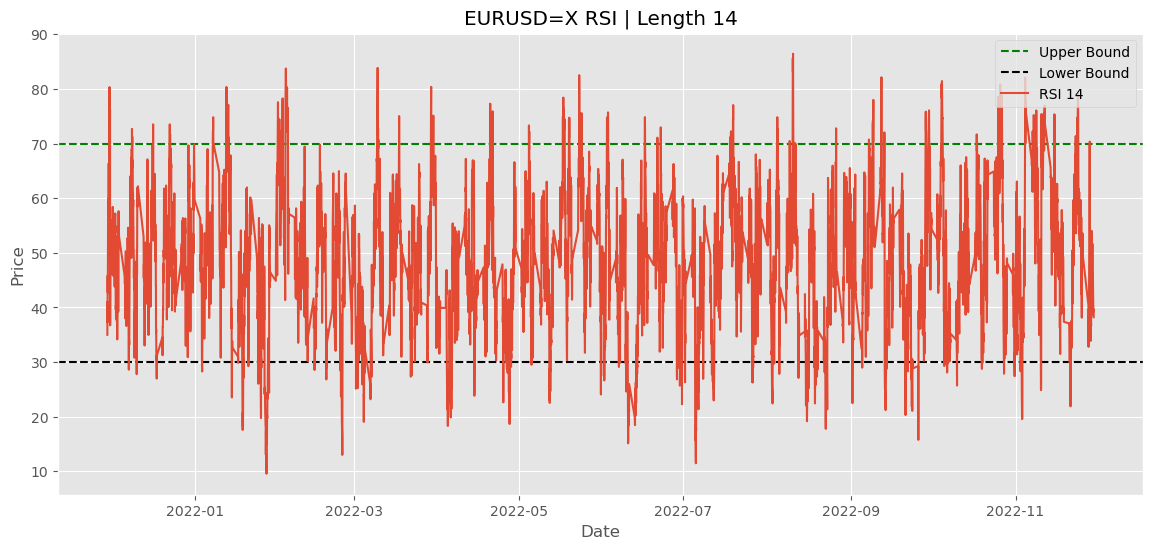

In [73]:
# Create f strings that match the column names created by the pandas ta library to reference the column data
str_rsi_col = f"RSI_{init_rsi_len}"
rsi_max = rsi_plot_insample_df[str_rsi_col].max()

# Plot the Bollinger Bands
plt.figure(figsize = (14,6))
plt.title(forex_pair+" RSI | Length "+str(init_rsi_len))
plt.axhline(y=70, linestyle='dashed', xmin = 0, xmax = rsi_max, color='green', label='Upper Bound')
plt.axhline(y=30, linestyle='dashed', xmin = 0, xmax = rsi_max, color='black', label='Lower Bound')
plt.plot(rsi_plot_insample_df[str_rsi_col], label = 'RSI '+str(init_rsi_len))
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(loc='upper right')
plt.show()

**c) Moving Average Convergence Divergence (MACD)**

Create variables for the initial fast, slow and signal values

In [74]:
init_fast = 12
init_slow = 26
init_signal = 9

In [75]:
macd_plot_insample_df = insample_data.copy()
macd_plot_insample_df.ta.macd(close = 'Close', fast = init_fast, slow = init_slow, append = True)
macd_plot_insample_df.tail()

,Open,High,Low,Close,Adj Close,Volume,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9
Datetime,,,,,,,,,
2022-11-29 19:00:00+00:00,1.034340,1.034875,1.032631,1.033058,1.033058,0,-0.001154,-0.000292,-0.000861
2022-11-29 20:00:00+00:00,1.033058,1.033378,1.032524,1.032951,1.032951,0,-0.001263,-0.000321,-0.000941
2022-11-29 21:00:00+00:00,1.032844,1.033378,1.032738,1.032844,1.032844,0,-0.001343,-0.000321,-0.001022
2022-11-29 22:00:00+00:00,1.033165,1.034340,1.032951,1.032951,1.032951,0,-0.001381,-0.000288,-0.001094
2022-11-29 23:00:00+00:00,1.033378,1.033378,1.032205,1.032418,1.032418,0,-0.001438,-0.000276,-0.001163


Plot the MACD graph

C:\Users\Sama\AppData\Local\Temp\ipykernel_1132\1999368742.py:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,1,1)


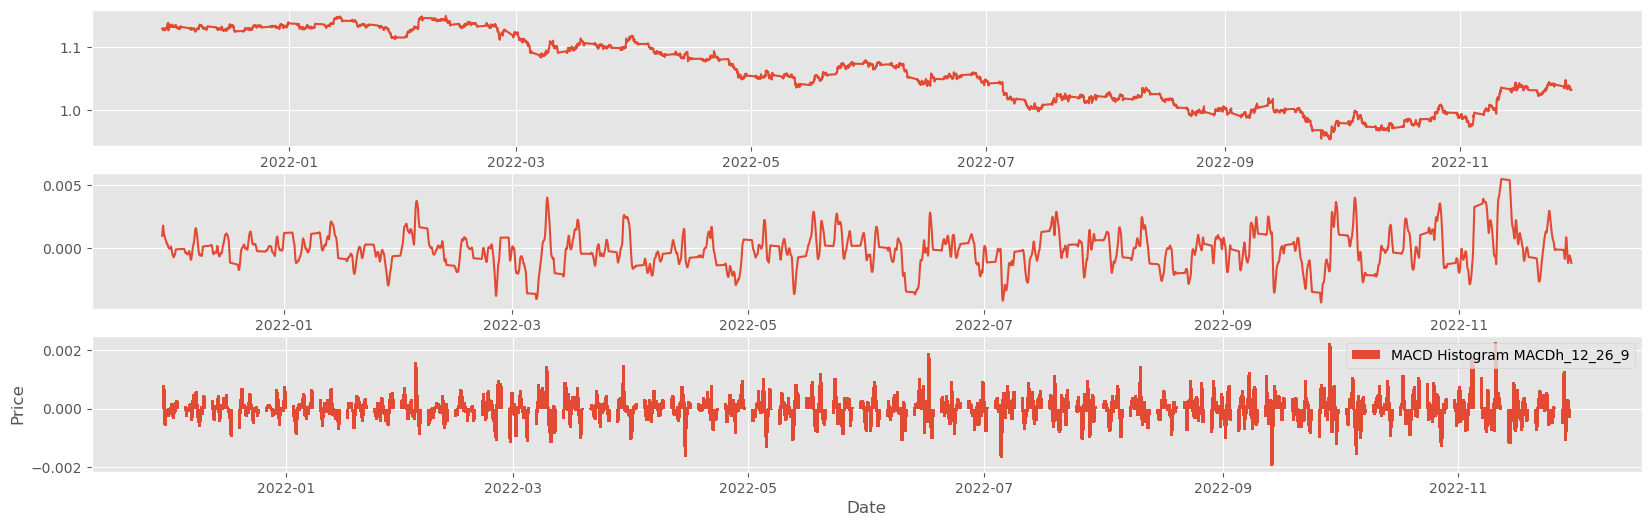

In [76]:
# Create f strings that match the column names created by the pandas ta library to reference the column data
str_macd = f"MACD_{init_fast}_{init_slow}_{init_signal}"
str_macd_h = f"MACDh_{init_fast}_{init_slow}_{init_signal}"
str_macd_s = f"MACDs_{init_fast}_{init_slow}_{init_signal}"

# Plot the Bollinger Bands
plt.figure(figsize = (20,6))
plt.title(f"{forex_pair} MACD | Fast {init_fast} | Slow {init_slow} | Signal {init_signal}")
plt.subplot(3,1,1)
plt.plot(macd_plot_insample_df['Close'], label = 'MACD '+str(str_macd))
plt.subplot(3,1,2)
plt.plot(macd_plot_insample_df[str_macd_s], label = 'MACD Slow '+str(str_macd_s))
plt.subplot(3,1,3)
plt.bar(macd_plot_insample_df.index, macd_plot_insample_df[str_macd_h],
        label = 'MACD Histogram '+str(str_macd_h))
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(loc='upper right')
plt.show()

**d) Simple Moving Average Strategy**

Create variables for the initial length and offset

In [112]:
init_sma_len = 30

In [113]:
# Create f strings that match the column names created by the pandas ta library to reference the column data
str_sma_col = f"SMA_{init_sma_len}"

In [114]:
sma_plot_insample_df = insample_data.copy()
sma_plot_insample_df[str_sma_col] = ta.sma(sma_plot_insample_df["Close"], length=init_sma_len)
sma_plot_insample_df.tail()

,Open,High,Low,Close,Adj Close,Volume,SMA_30
Datetime,,,,,,,
2022-11-29 19:00:00+00:00,1.034340,1.034875,1.032631,1.033058,1.033058,0,1.036540
2022-11-29 20:00:00+00:00,1.033058,1.033378,1.032524,1.032951,1.032951,0,1.036202
2022-11-29 21:00:00+00:00,1.032844,1.033378,1.032738,1.032844,1.032844,0,1.035966
2022-11-29 22:00:00+00:00,1.033165,1.034340,1.032951,1.032951,1.032951,0,1.035769
2022-11-29 23:00:00+00:00,1.033378,1.033378,1.032205,1.032418,1.032418,0,1.035598


Plot the momentum graph

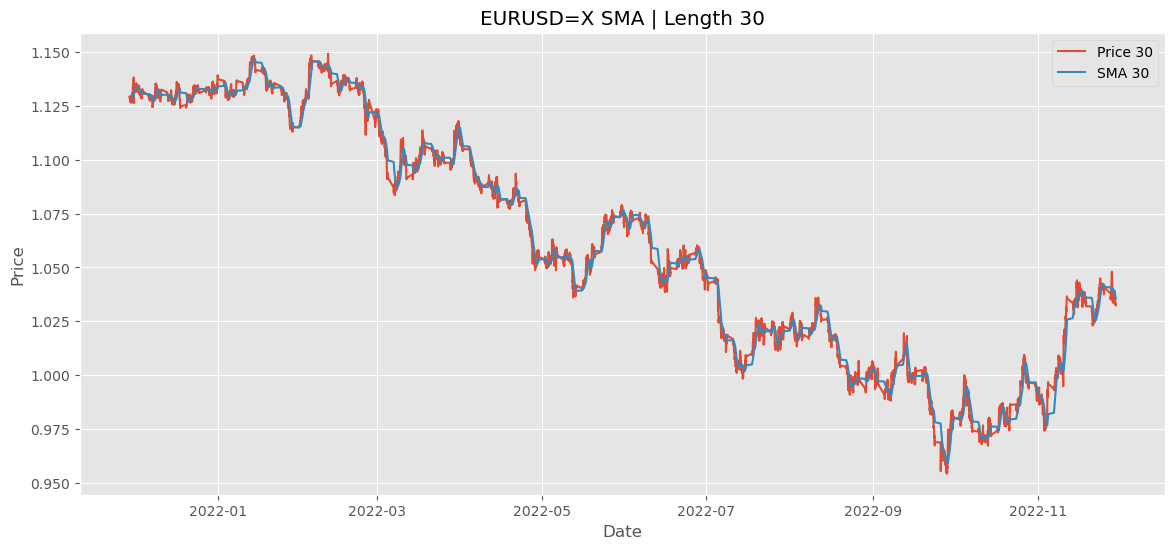

In [117]:
# Plot the charts
plt.figure(figsize = (14,6))
plt.title(forex_pair+" SMA | Length "+str(init_sma_len))
plt.plot(mom_plot_insample_df['Close'], label = 'Price '+str(init_sma_len))
plt.plot(mom_plot_insample_df['SMA'], label = 'SMA '+str(init_sma_len))
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

### Backtest Setup

Define the Bollinger Bands Indicator and Buy / Sell Strategy that the backtesting.py library will optimize

In [129]:
def bands_indicator(data, window, std_dev):
    
    """

    Defines the indicator that will be used by the backtesting.py Strategy class.
    Uses the pandas ta library to create and return Bollinger Bands to the Strategy class.

    Parameters
    ----------
    data : Dataframe
        The Dataframe containing the closing prices that the Bollinger Bands will be created for
    window : int
        The exponential moving average window to use when calculating the exponential moving average of the closing prices
    std_dev : float
        The standard deviation that indicates the level above and below the the simple moving average of the closing price

    Returns
    -------
    series
        The Bollinger Bands upper, middle and lower bands as a numpy series

    """
    
    bbands = ta.bbands(close = data.Close.s, length = window, std = std_dev, mamode="ema")
    return bbands.to_numpy().T[:3]

class BollingerBandsStrategy(Strategy):
    
    """

    Extends from the backtesting.py Strategy Class to create the Bollinger Bands indicator and define the sell and buy rules
    
    Attributes
    ----------
    ema_window : float
        The exponential moving average window to use when calculating the exponential moving average of the closing prcies
    std : float
        The standard deviation that indicates the level above and below the the simple moving average of the closing price
        
    Methods
    -------
    init()
        Creates Bollinger Bands using the indicator() function defined above
        
    next()
        Define the trading logic for the strategy


    """
    
    ema_window = 0
    std = 0
        
    def init(self):
        """
        Creates Bollinger Bands using the indicator() function defined

        Returns
        -------
        series
            The Bollinger Bands upper, middle and lower bands as a numpy series
        """
        
        self.bbands = self.I(bands_indicator, self.data, self.ema_window, self.std)
        
    def next(self):
        """
        Define the trading logic for the strategy. If the closing price crosses above the upper Bollinger Band, 
        close the trade. If the closing price crosses below the lower Bollinger band, place a new long order using
        the backtesting.py buy() function

        Returns
        -------
        None
        """
        
        lower_band = self.bbands[0]
        upper_band = self.bbands[2]
        
        if self.position:
            if crossover(self.data.Close, upper_band):
                self.position.close()
        else:
            if crossover(lower_band, self.data.Close):
                self.buy()

Define the RSI Indicator and Buy / Sell Strategy that the backtesting.py library will optimize

In [186]:
def rsi_indicator(data, length, scalar):
    
    """

    Defines the indicator that will be used by the backtesting.py Strategy class.
    Uses the pandas ta library to create and return Bollinger Bands to the Strategy class.

    Parameters
    ----------
    data : Dataframe
        The Dataframe containing the closing prices that the Bollinger Bands will be created for
    length : int
        The window of days to use when calculating the Relative Strength Index of the closing prices
    scalar : int
        The scale by which to magnify the Relative Strength Index of the closing prices

    Returns
    -------
    series
        The RSI upper, middle and lower bands as a numpy series

    """
    
    rsi = ta.rsi(close = data.Close.s, length = length, scalar = scalar)
    return rsi.to_numpy()

class RSIStrategy(Strategy):
    
    """

    Extends from the backtesting.py Strategy Class to create the RSI indicator and define the sell and buy rules
    
    Attributes
    ----------
    rsi_length : float
        The window of days to use when calculating the Relative Strength Index of the closing prices
    rsi_scalar : float
        The scale by which to magnify the Relative Strength Index of the closing prices
        
    Methods
    -------
    init()
        Creates the Relative Strength Index using the indicator() function defined above
        
    next()
        Define the trading logic for the strategy


    """
    
    rsi_length = 14
    rsi_scalar = 100
        
    def init(self):
        """
        Creates Relative Strength Index using the indicator() function defined

        Returns
        -------
        series
            The Relative Strength Index numpy series
        """
        
        self.rsi = self.I(rsi_indicator, self.data, self.rsi_length, self.rsi_scalar)
        
    def next(self):
        """
        Define the trading logic for the strategy. If the closing price crosses above the upper RSI threshold, 
        close the trade. If the closing price crosses below the lower RSI threshold, place a new long order using
        the backtesting.py buy() function

        Returns
        -------
        None
        """
        
        rsi = self.rsi
        rsi_lower = 30
        rsi_upper = 70
        
        if self.position:
            if crossover(rsi, rsi_upper):
                self.position.close()
        else:
            if crossover(rsi, rsi_lower):
                self.buy()

Create and an instance of our Backtest class using:
- The **'insample_dataset'** from section 2
- Cash of $10,000
- Commission at 0.25% per trade
- EMA window of 20
- Standard Deviation of 2

In [181]:
bt = Backtest(insample_data, BollingerBandsStrategy, cash=10_000, commission=0.0024)
stats = bt.run(ema_window = init_ema_window, std = init_std)

In [187]:
bt_rsi = Backtest(insample_data, RSIStrategy, cash=10_000, commission=0.0024)
stats_rsi = bt_rsi.run(rsi_length = 14, rsi_scalar = 100)

Create a table with the Sharpe Ratio, Proft and Loss (PnL) and Return percentage from the backtest

In [108]:
pnl_backtest = np.cumsum(stats['_trades'])
pnl_backtest_val = pnl_backtest['PnL'].iloc[-1]

In [109]:
backtest_results_table = [
    ["Start Date",stats['Start']],
    ["End Date",stats['End']],
    ["Peak Equity",stats['Equity Peak [$]']],
    ["Final Equity",stats['Equity Final [$]']],
    ["Sharpe Ratio",round(stats['Sharpe Ratio'], 5)], 
    ["PnL", f"${round(pnl_backtest_val, 3)}"],
    ["Return %", f"{round(stats['Return [%]'], 3)}%"],
    ["Win Rate [%]", f"{round(stats['Win Rate [%]'], 3)}%"],
    ["Number of trades",len(stats['_trades'])]
]

print(f"Backesting results with investment of {10000} and commission of 0.25%\n")
print(tabulate(backtest_results_table, headers=["Result", "Value"]))    

Backesting results with investment of 10000 and commission of 0.25%

Result            Value
----------------  -------------------------
Start Date        2021-11-15 00:00:00+00:00
End Date          2022-11-15 23:00:00+00:00
Peak Equity       10103.125981879337
Final Equity      8815.089452679169
Sharpe Ratio      0.0
PnL               $-1184.911
Return %          -11.849%
Win Rate [%]      57.143%
Number of trades  21


Plot the Close-to-Close equity lines

In [110]:
backtest_pnl = pd.DataFrame(stats['_trades']["PnL"].copy())
backtest_pnl["PnL CumSum"] = backtest_pnl["PnL"].cumsum()

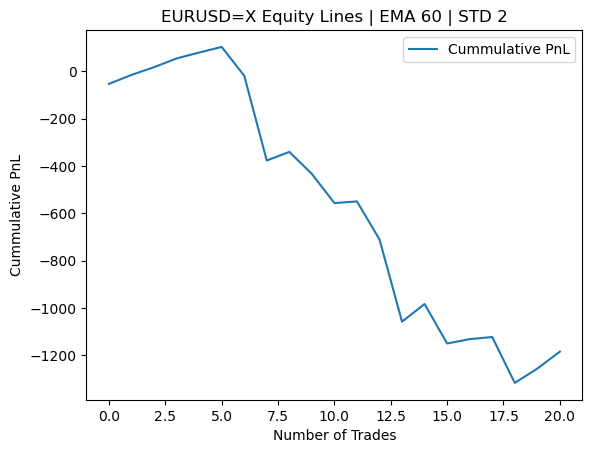

In [111]:
# Plot the cummulative PnL from the backtest
plt.title(forex_pair+" Equity Lines | EMA "+str(init_ema_window)+" | STD "+str(init_std))
plt.plot(
    backtest_pnl.index,
    backtest_pnl["PnL CumSum"],
    label = "Cummulative PnL")
plt.xlabel("Number of Trades")
plt.ylabel("Cummulative PnL")
plt.legend(loc='upper right')
plt.show()

### 2.3 Optmizing strategy to select best-performing hyperparameters

Run the backesting.py **optimize()** function using the Simple Moving Average Window and Standard Deviation as the parameters to optmize

In [94]:
optimized_stats, heatmap = bt.optimize(
    ema_window = range(20, 71, 1),
    std = list(np.round(np.linspace(1, 3, 11), 1)),
    maximize = 'Equity Final [$]',
    return_heatmap = True
)

hm = heatmap.groupby(["ema_window", "std"]).mean().unstack()

C:\Users\Sama\anaconda3\Lib\site-packages\backtesting\backtesting.py:1488: UserWarning: Searching for best of 561 configurations.
  output = _optimize_grid()


  0%|          | 0/13 [00:00<?, ?it/s]

Create a second table with the Sharpe Ratio, Proft and Loss (PnL) and Return percentage from the optimized backtest

In [31]:
pnl_optimized = np.cumsum(optimized_stats['_trades'])
pnl_optimized_val = pnl_optimized['PnL'].iloc[-1]

In [60]:
optimized_backtest_results_table = [
    ["Start Date", optimized_stats['Start']],
    ["End Date", optimized_stats['End']],
    ["Peak Equity", optimized_stats['Equity Peak [$]']],
    ["Final Equity",optimized_stats['Equity Final [$]']],
    ["Sharpe Ratio", round(optimized_stats['Sharpe Ratio'], 5)], 
    ["PnL", f"${round(pnl_optimized_val,3)}"],
    ["Return %", f"{round(optimized_stats['Return [%]'], 3)}%"],
    ["Win Rate [%]", f"{round(optimized_stats['Win Rate [%]'], 3)}%"],
    ["Number of trades", len(optimized_stats['_trades'])]
]

print(f"Backesting reults with EMA Window and Standard Deviation optimized\n")
print(tabulate(optimized_backtest_results_table, headers=["Result", "Value"]))                         

Backesting reults with EMA Window and Standard Deviation optimized

Result            Value
----------------  -------------------------
Start Date        2021-11-15 00:00:00+00:00
End Date          2022-11-14 23:00:00+00:00
Peak Equity       10029.811521748463
Final Equity      8916.765280589769
Sharpe Ratio      0.0
PnL               $306.071
Return %          -10.832%
Win Rate [%]      42.105%
Number of trades  19


Plot the close-to-close equity lines

In [55]:
validate_pnl = pd.DataFrame(optimized_stats['_trades']["PnL"].copy())
validate_pnl["PnL CumSum"] = validate_pnl["PnL"].cumsum()

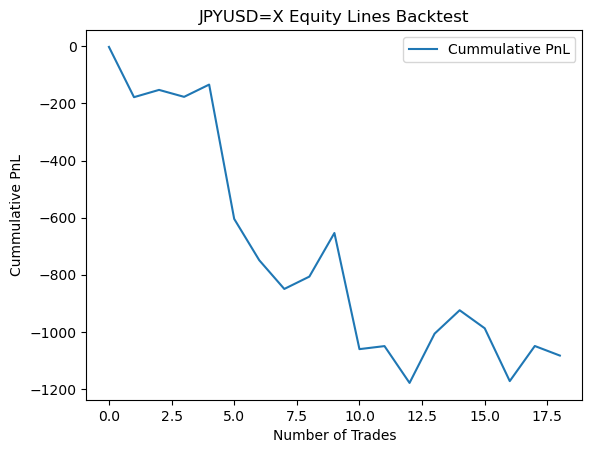

In [56]:
# Plot the cummulative PnL from the optimized backtest
plt.title(forex_pair+" Equity Lines Backtest")
plt.plot(
    validate_pnl.index,
    validate_pnl["PnL CumSum"],
    label = "Cummulative PnL")
plt.xlabel("Number of Trades")
plt.ylabel("Cummulative PnL")
plt.legend(loc='upper right')
plt.show()

Plot a heatmap of the best-performing hyperparameters

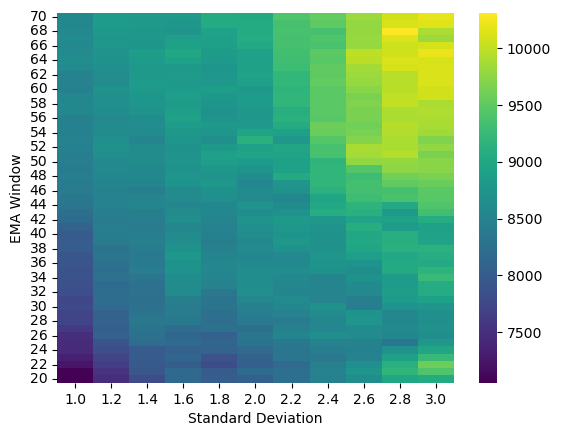

In [35]:
pricing_hm = sns.heatmap(hm[::-1], cmap='viridis')
pricing_hm.set(xlabel='Standard Deviation', ylabel='EMA Window')
plt.show()

### 2.4 Cross validation

Get the optimal parameters

In [36]:
optimized_std = optimized_stats['_strategy'].std
optimized_window = optimized_stats['_strategy'].ema_window

print(f"Optimal standard deviation is {optimized_std}")
print(f"Optimal EMA Window is {optimized_window}")

Optimal standard deviation is 2.8
Optimal EMA Window is 68


Run an instance of our Backtest class using  from section 2 using:
- The **'outsample_dataset'** from section 1.1
- Cash of $10,000
- Commission at 1%
- The optimized EMA window
- The optimized standard deviation

In [37]:
bt_optimal = Backtest(outsample_data, BollingerBandsStrategy, cash=10_000, commission=0.0024)
stats_optimal = bt_optimal.run(ema_window = optimized_window, std = optimized_std)

Create a table with the Sharpe Ratio, Proft and Loss (PnL) and Return percentage from the backtest

In [38]:
pnl_rerun = np.cumsum(stats_optimal['_trades'])
pnl_rerun_val = pnl_rerun['PnL'].iloc[-1]

In [61]:
optimized_backtest_results_table = [
    ["Start Date", stats_optimal['Start']],
    ["End Date", stats_optimal['End']],
    ["Peak Equity", stats_optimal['Equity Peak [$]']],
    ["Final Equity",stats_optimal['Equity Final [$]']],
    ["Sharpe Ratio", round(stats_optimal['Sharpe Ratio'], 5)], 
    ["PnL", f"${round(pnl_rerun_val,3)}"],
    ["Return %", f"{round(stats_optimal['Return [%]'], 3)}%"],
    ["Win Rate [%]", f"{round(stats_optimal['Win Rate [%]'], 3)}%"],
    ["Number of trades", len(stats_optimal['_trades'])]
]

print(f"Backesting optimized reults with investment of {10000} and commission of 1%\n")
print(tabulate(optimized_backtest_results_table, headers=["Result", "Value"]))                         

Backesting optimized reults with investment of 10000 and commission of 1%

Result            Value
----------------  -------------------------
Start Date        2022-11-15 00:00:00+00:00
End Date          2023-11-13 15:00:00+00:00
Peak Equity       11032.253401723101
Final Equity      10550.156380348782
Sharpe Ratio      0.98012
PnL               $550.156
Return %          5.502%
Win Rate [%]      70.0%
Number of trades  10


Plot Close to Close Equity Lines

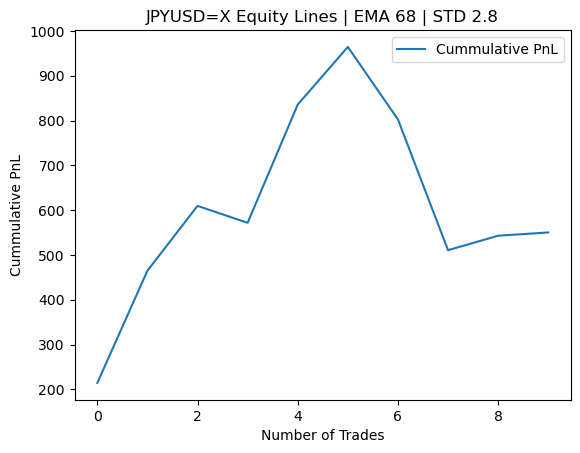

In [62]:
rerun_pnl = pd.DataFrame(stats_optimal['_trades']["PnL"].copy())
rerun_pnl["PnL CumSum"] = rerun_pnl["PnL"].cumsum()

# Plot the cummulative PnL from the cross-validation
plt.title(forex_pair+" Equity Lines | EMA "+str(optimized_window)+" | STD "+str(optimized_std))
plt.plot(
    rerun_pnl.index,
    rerun_pnl["PnL CumSum"],
    label = "Cummulative PnL")
plt.xlabel("Number of Trades")
plt.ylabel("Cummulative PnL")
plt.legend(loc='upper right')
plt.show()

### 3. Backtesting, Cross-Validation and Saving Metrics for more currency pairs

Create a list of the currency pairs to test, excluding EUR/USD

In [64]:
currency_pairs = ['USDJPY=X',
                  'GBPUSD=X']

Create the direcories insample and outsample to hold the insample and outsample data

In [73]:
insample_dir = 'insample'
if not os.path.exists(insample_dir):
    os.mkdir(insample_dir)
    
outsample_dir = 'outsample'
if not os.path.exists(outsample_dir):
    os.mkdir(outsample_dir)

Download the data from the API for each and save it into a csv file

In [74]:
for forex_pair in currency_pairs:
    
    data = yf.download(forex_pair, interval = interval, start = start_date)

    # Slice the downloaded two-year data into two datasets
    fx_insample_data = pd.DataFrame(data.loc[last_729_days_date : slice_one_end_date].copy())
    fx_outsample_data = pd.DataFrame(data.loc[slice_two_start_date:today].copy())
    
    insample_filename = "insample_"+forex_pair+".csv"
    outsample_filename = "outsample_"+forex_pair+".csv"
    
    # Save the CSV files to their respective directories
    fx_insample_data.to_csv("insample/"+insample_filename)
    fx_outsample_data.to_csv("outsample/"+outsample_filename)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


### 3.1 Backtest and save historical data

Define the function that will run the backtests for the currency pair list above using the strategy **BollingerBandsStrategy**. Backtest the 15 currency pairs with the bollinger bands strategy, using the saved historical data for 2005 to 2013 in the directory backtestdata/

In [75]:
def backtest_strategy(param_cash, param_commission):
    
    """
    Runs the backtesting BollingerBandsStrategy strategy on the currency pair data in the insample directory
    using the default EMA of 60 and Standard Deviation of 2

    Parameters
    ----------
    param_cash : int
        The amount of money that will be traded in the backtest
    param_commission : float
        The percentage commission that will be given to the broker for each trade executed

    Returns
    -------
    insample_file_data : list
        A list of backtest statistics and optimized parameters for each currency pair dataset in the insample directory

    """
    
    index = 0
    insample_file_data = []
    insample_files = os.listdir(insample_dir)
    
    while index < len(insample_files):
        try:
            filename = insample_dir + "/" + insample_files[index]
            symbol = filename[18:26]
            
            file_data = pd.read_csv(filename)
            
            data_df = file_data.copy()
            data_df.index = pd.DatetimeIndex(pd.to_datetime(data_df['Datetime'], utc=True))
            data_df.sort_index(ascending=True, inplace=True)
            
            bt = Backtest(data_df, BollingerBandsStrategy, cash = param_cash, commission = param_commission)
            stats = bt.run(ema_window=init_ema_window, std=init_std)

            optimized_stats = bt.optimize(
                ema_window=range(20, 71, 1),
                std=list(np.round(np.linspace(1, 3, 11), 1)),
                maximize='Equity Final [$]',
                return_heatmap=False
            )
            
            optmized_std = optimized_stats['_strategy'].std
            optimized_window = optimized_stats['_strategy'].ema_window
            
            insample_file_data.append(list([symbol, stats, optmized_std, optimized_window]))
        
        except FileNotFoundError:
            print(f"File {filename} not found")
        
        except ValueError:
            continue
        
        finally:
            index += 1
            
    return insample_file_data

In [76]:
bulk_backtest_results = backtest_strategy(10_000, 0.0024)

C:\Users\Sama\anaconda3\Lib\site-packages\backtesting\backtesting.py:1488: UserWarning: Searching for best of 561 configurations.
  output = _optimize_grid()


  0%|          | 0/13 [00:00<?, ?it/s]

C:\Users\Sama\anaconda3\Lib\site-packages\backtesting\backtesting.py:1488: UserWarning: Searching for best of 561 configurations.
  output = _optimize_grid()


  0%|          | 0/13 [00:00<?, ?it/s]

KeyboardInterrupt: 

Save the **backtest** metrics into a list and write the data into a csv file

In [ ]:
backtest_metrics = []
backtest_header = ["Currency Pair", "Start Date", "End Date", "Duration", "Exposure Time %", "Final Equity $", "Peak Equity $",
                   "Return %", "Buy & Hold Return %", "Annual Return %", "Annual Volatility %", "Sharpe Ratio",
                   "Sortino Ratio", "Calmar Ratio", "Max. Drawdown %", "Avg. Drawdown %", "Max. Drawdown Duration",
                   "Avg. Drawdown Duration", "Number of Trades", "Win Rate %", "Best Trade %", "Worst Trade %",
                   "Avg. Trade %", "Max. Trade Duration", "Avg. Trade Duration", "Profit Factor", "Expectancy $", "SQN",
                   "Optimal STD", "Optimal EMA"]


for result in bulk_backtest_results:
    if(len(result[1]['_trades']) > 0):
        pnl_col = np.cumsum(result[1]['_trades']['PnL'])
        result_pnl = pnl_col.iloc[-1]
    else:
        result_pnl = 0

    backtest_metrics.append(list([
        result[0],
        result[1]['Start'],
        result[1]['End'],
        result[1]['Duration'],
        result[1]['Exposure Time [%]'],
        result[1]['Equity Final [$]'],
        result[1]['Equity Peak [$]'],
        result[1]['Return [%]'],
        result[1]['Buy & Hold Return [%]'],
        result[1]['Return (Ann.) [%]'],
        result[1]['Volatility (Ann.) [%]'],
        result[1]['Sharpe Ratio'],
        result[1]['Sortino Ratio'],
        result[1]['Calmar Ratio'],
        result[1]['Max. Drawdown [%]'],
        result[1]['Avg. Drawdown [%]'],
        result[1]['Max. Drawdown Duration'],
        result[1]['Avg. Drawdown Duration'],
        result[1]['# Trades'],
        result[1]['Win Rate [%]'],
        result[1]['Best Trade [%]'],
        result[1]['Worst Trade [%]'],
        result[1]['Avg. Trade [%]'],
        result[1]['Max. Trade Duration'],
        result[1]['Avg. Trade Duration'],
        result[1]['Profit Factor'],
        result[1]['Expectancy [%]'],
        result[1]['SQN'],
        result[2],
        result[3]
    ]))


Write the data to the file **backtest_metrics.csv**

In [ ]:
with open('backtest_metrics.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)

    # Write the header to the CSV file
    writer.writerow(backtest_header)

    # Write each item in the backtest_metrics list as a row in the CSV file
    writer.writerows(backtest_metrics)

### 3.2 Cross-validate and save cross-validation data

Define the function that will run the backtests for the currency pair list above using the strategy **OptBollingerBandsStrategy**. Backtest the 15 currency pairs with the optimized bollinger bands strategy, using the saved data for 2013 to 2022 in the directory rerundata/

In [ ]:
insample_file_data = []

def validate_strategy(param_cash, param_commission):
    """
    Cross-validates the strategy by running the backtesting BollingerBandsStrategy strategy on the currency pair data
    in the outsample directory. The optimal EMA and Standard Deviation used for each currency pair dataset are selected from
    the backtest optimization

    Parameters
    ----------
    param_cash : int
        The amount of money that will be traded in the backtest
    param_commission : float
        The percentage commission that will be given to the broker for each trade executed

    Returns
    -------
    outsample_file_data : list
        A list of cross-validation statistics for each currency pair dataset in the outsample directory

    """
    index = 0
    outsample_file_data = []
    outsample_files = os.listdir(outsample_dir)
    
    while index < len(outsample_files):
        try:
            filename = outsample_dir + "/" + outsample_files[index]
            symbol = filename[20:26]
            
            file_data = pd.read_csv(filename)   
            
            data_df = file_data.copy()
            data_df.index = pd.DatetimeIndex(pd.to_datetime(data_df['Datetime'], utc=True))
            data_df.sort_index(ascending=True, inplace=True)
            
            # Select the optimal EMA Window and Standard Deviation from the backtest metrics file
            metrics_data = pd.read_csv('backtest_metrics.csv')
            optimal_ema = metrics_data.loc[metrics_data["Currency Pair"] == symbol + "=X"]["Optimal EMA"][index]
            optimal_std = metrics_data.loc[metrics_data["Currency Pair"] == symbol + "=X"]["Optimal STD"][index]
            
            bt = Backtest(data_df, BollingerBandsStrategy, cash=param_cash, commission=param_commission)
            stats = bt.run(ema_window=optimal_ema, std=optimal_std)

            outsample_file_data.append(list([symbol, stats]))
            
        except FileNotFoundError:
            print(f"File {filename} not found")
        
        except ValueError:
            continue
            
        finally:
            index += 1
            
    return outsample_file_data

In [ ]:
bulk_validate_results = validate_strategy(10_000, 0.0024)

Save the **validation** metrics into a list and write the data into a csv file

In [ ]:
validate_metrics = []
for result in bulk_validate_results:
    if(len(result[1]['_trades']) > 0):
        pnl_col = np.cumsum(result[1]['_trades']['PnL'])
        result_pnl = pnl_col.iloc[-1]
    else:
        result_pnl = 0

    validate_metrics.append(list([
        result[0],
        result[1]['Start'],
        result[1]['End'],
        result[1]['Duration'],
        result[1]['Exposure Time [%]'],
        result[1]['Equity Final [$]'],
        result[1]['Equity Peak [$]'],
        result[1]['Return [%]'],
        result[1]['Buy & Hold Return [%]'],
        result[1]['Return (Ann.) [%]'],
        result[1]['Volatility (Ann.) [%]'],
        result[1]['Sharpe Ratio'],
        result[1]['Sortino Ratio'],
        result[1]['Calmar Ratio'],
        result[1]['Max. Drawdown [%]'],
        result[1]['Avg. Drawdown [%]'],
        result[1]['Max. Drawdown Duration'],
        result[1]['Avg. Drawdown Duration'],
        result[1]['# Trades'],
        result[1]['Win Rate [%]'],
        result[1]['Best Trade [%]'],
        result[1]['Worst Trade [%]'],
        result[1]['Avg. Trade [%]'],
        result[1]['Max. Trade Duration'],
        result[1]['Avg. Trade Duration'],
        result[1]['Profit Factor'],
        result[1]['Expectancy [%]'],
        result[1]['SQN'],
        result[2],
        result[3]
    ]))


Write the data to the file **validation_metrics.csv**

In [ ]:
validation_header = ["Currency Pair", "Start Date", "End Date", "Duration", "Exposure Time %", "Final Equity $", "Peak Equity $",
                   "Return %", "Buy & Hold Return %", "Annual Return %", "Annual Volatility %", "Sharpe Ratio",
                   "Sortino Ratio", "Calmar Ratio", "Max. Drawdown %", "Avg. Drawdown %", "Max. Drawdown Duration",
                   "Avg. Drawdown Duration", "Number of Trades", "Win Rate %", "Best Trade %", "Worst Trade %",
                   "Avg. Trade %", "Max. Trade Duration", "Avg. Trade Duration", "Profit Factor", "Expectancy $", "SQN",
                   "Optimal STD", "Optimal EMA"]

In [ ]:
with open('validation_metrics.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)

    # Write the header to the CSV file
    writer.writerow(validation_header)

    # Write each item in the validate_metrics list as a row in the CSV file
    writer.writerows(validate_metrics)

## 4. Unit Testing

Define a class TestSuite that tests different scenarios for our backtests

In [ ]:
class TestSuite(unittest.TestCase):
    def test_data_loading(self):
        # Test that the data loading function correctly loads and processes the data
        price_data = yf.download(forex_pair, interval = interval, start = start_date)

        # Assert that the loaded data is not empty
        self.assertFalse(price_data.empty)

    def test_valid_currency_pair(self):
        # Test that the data loading function only accepts valid currency pairs
        price_data = yf.download("XYZ", interval = interval, start = start_date)

        # Assert that the loaded data is not empty
        self.assertTrue(price_data.empty)
        
    def test_backtest_amount(self):
        cash =  10000
        bt = Backtest(insample_data, BollingerBandsStrategy, cash=cash, commission=0.0024)
        stats = bt.run(ema_window = init_ema_window, std = init_std)
        
        # Assert that the statistics generated are valid
        self.assertNotEqual(cash, 0)

Create a test suite and run the tests

In [ ]:
test_suite = unittest.TestLoader().loadTestsFromTestCase(TestSuite)
unittest.TextTestRunner(verbosity=2).run(test_suite)